# Pb from BC parameterization (Villum)

Villum (Northern Greenland)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy
import pandas as pd
import datetime
from matplotlib.dates import date2num, num2date
import matplotlib.dates as mdates
import calendar
import seaborn as sns
from scipy.optimize import leastsq
from scipy.stats import pearsonr, spearmanr
import xarray as xr

%matplotlib inline

Parameters:

In [57]:
months = mdates.MonthLocator()  # every month

# Colors:
color_Pb = '#625b62'
color_BC = '#b2b2b2'

Functions

In [3]:
def toTimestamp(d):
    return calendar.timegm(d.timetuple())

In [4]:
def smooth(x,window_len=11,window='hanning'):
    """smooth the data using a window with requested size.
    
    This method is based on the convolution of a scaled window with the signal.
    The signal is prepared by introducing reflected copies of the signal 
    (with the window size) in both ends so that transient parts are minimized
    in the begining and end part of the output signal.
    
    input:
        x: the input signal 
        window_len: the dimension of the smoothing window; should be an odd integer
        window: the type of window from 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'
            flat window will produce a moving average smoothing.

    output:
        the smoothed signal
    """

    if x.ndim != 1:
        raise ValueError#, "smooth only accepts 1 dimension arrays."

    if x.size < window_len:
        raise ValueError#, "Input vector needs to be bigger than window size."

    if window_len<3:
        return x

    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError#, "Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'"

    s=np.r_[x[window_len-1:0:-1],x,x[-2:-window_len-1:-1]]
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('numpy.'+window+'(window_len)')

    y=np.convolve(w/w.sum(),s,mode='valid')
    return y

In [5]:
def lin_fit(x, y):
    '''Fits a linear fit of the form mx+b to the data'''
    fitfunc = lambda params, x: params[0] * x  
    errfunc = lambda p, x, y: fitfunc(p, x) - y              #create error function for least squares fit

    init_a = 0.5                            #find initial value for a (gradient)
    init_p = np.array((init_a))  #bundle initial values in initial parameters

    #calculate best fitting parameters (i.e. ) using the error function
    p1, success = leastsq(errfunc, init_p.copy(), args = (x, y))
    f = fitfunc(p1, x)          #create a fit with those parameters
    return p1, f  

## Load data from Alert

In [135]:
Alert     = xr.open_dataset('/ocean/brogalla/GEOTRACES/data/Alert_1989-1992.nc')
Alert_EBC = Alert['EBC'].values*1e3 # ng/m3
Alert_EBC_dates = num2date(Alert['EBC_dates'].values)
Alert_Pb        = Alert['Pb'].values
Alert_Pb_dates  = num2date(Alert['Pb_dates'].values)

In [342]:
Alert_indx_BC = np.array([])
Alert_indx_Pb = np.array([])

for ind, Pb_date in enumerate(Alert_Pb_dates):
    if ind > 17: # overlapping time period
        # Find index of nearest BC date for each Pb measurement:
        difference = np.array([(Pb_date - EBC_date).total_seconds() for EBC_date in Alert_EBC_dates])
        indx_add = np.argmin(np.abs(difference))
        Alert_indx_BC  = np.append(Alert_indx_BC, int(indx_add))
        # And save index of Pb element too:
        Alert_indx_Pb  = np.append(Alert_indx_Pb, int(ind))

In [344]:
Alert_Pb_dates_overlap  = np.array([Alert_Pb_dates[int(ix)] for ix in Alert_indx_Pb])
Alert_Pb_overlap        = np.array([Alert_Pb[int(ix)] for ix in Alert_indx_Pb])
Alert_EBC_dates_overlap = np.array([Alert_EBC_dates[int(ix)] for ix in Alert_indx_BC])
Alert_EBC_overlap       = np.array([Alert_EBC[int(ix)] for ix in Alert_indx_BC])

(726251.708333, 727563.958333)

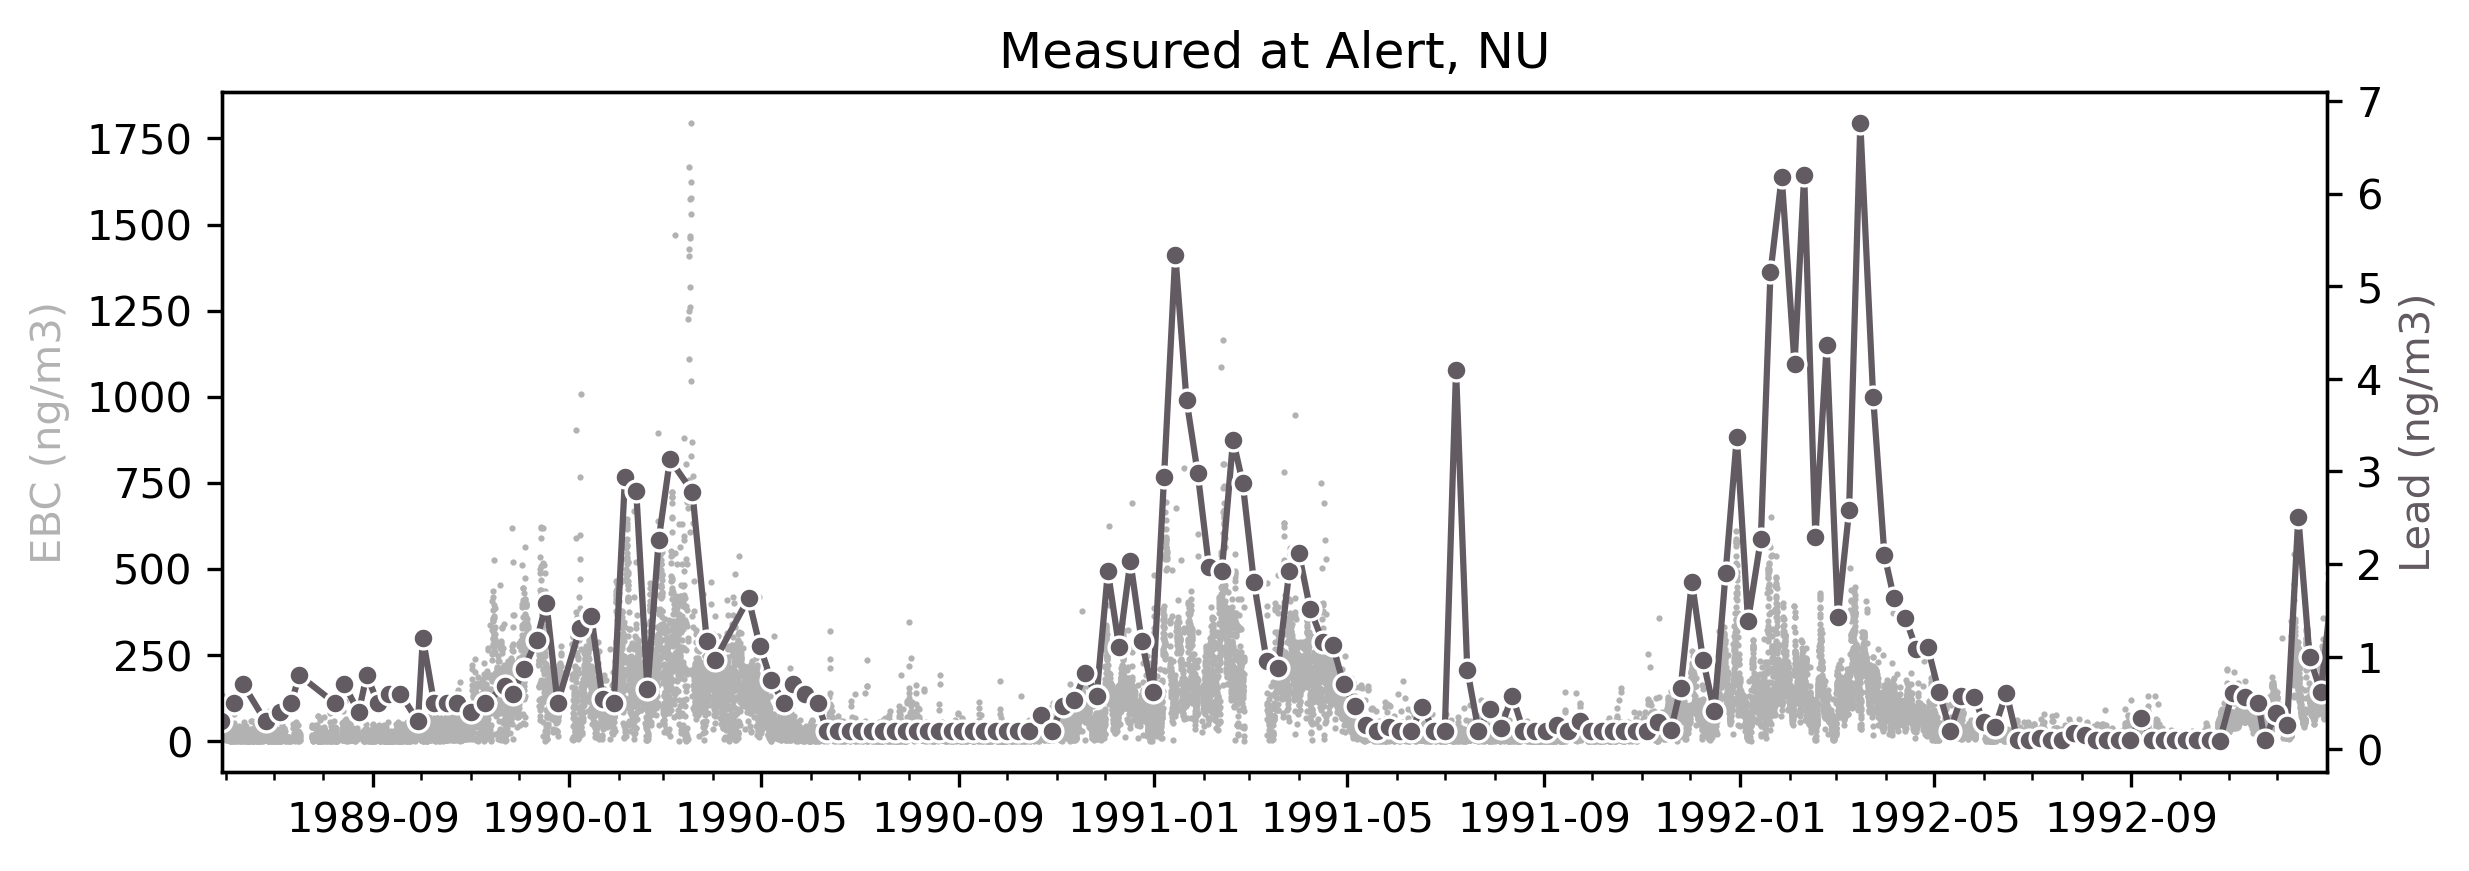

In [128]:
fig, ax1 = plt.subplots(1,1, figsize=(9.055, 3.0), dpi=300)
ax1.plot_date(Alert_EBC_dates, Alert_EBC,'.', color=color_BC, markersize=2, markeredgewidth=0.5)
ax1.set_xlim([Alert_EBC_dates[0], Alert_EBC_dates[-1]])
ax1.set_ylabel('EBC (ng/m3)', fontsize=10, color=color_BC)
ax1.xaxis.set_minor_locator(months)
ax1.set_title('Measured at Alert, NU')

ax2 = ax1.twinx()
ax2.plot_date(Alert_Pb_dates, Alert_Pb,'.-', color=color_Pb, markersize=10, markeredgecolor='w', markeredgewidth=0.8)
ax2.set_ylabel('Lead (ng/m3)', fontsize=10, color=color_Pb)
ax2.set_xlim([Alert_EBC_dates[0], Alert_EBC_dates[-1]])

In [114]:
Al_Pb_ave     = smooth(Alert_Pb, window_len=7, window='flat')
Al_EBC_ave    = smooth(Alert_EBC, window_len=999, window='flat')
Alert_Pb_ave  = Al_Pb_ave[3:-3]
Alert_EBC_ave = Al_EBC_ave[499:-499]

(726251.708333, 727563.958333)

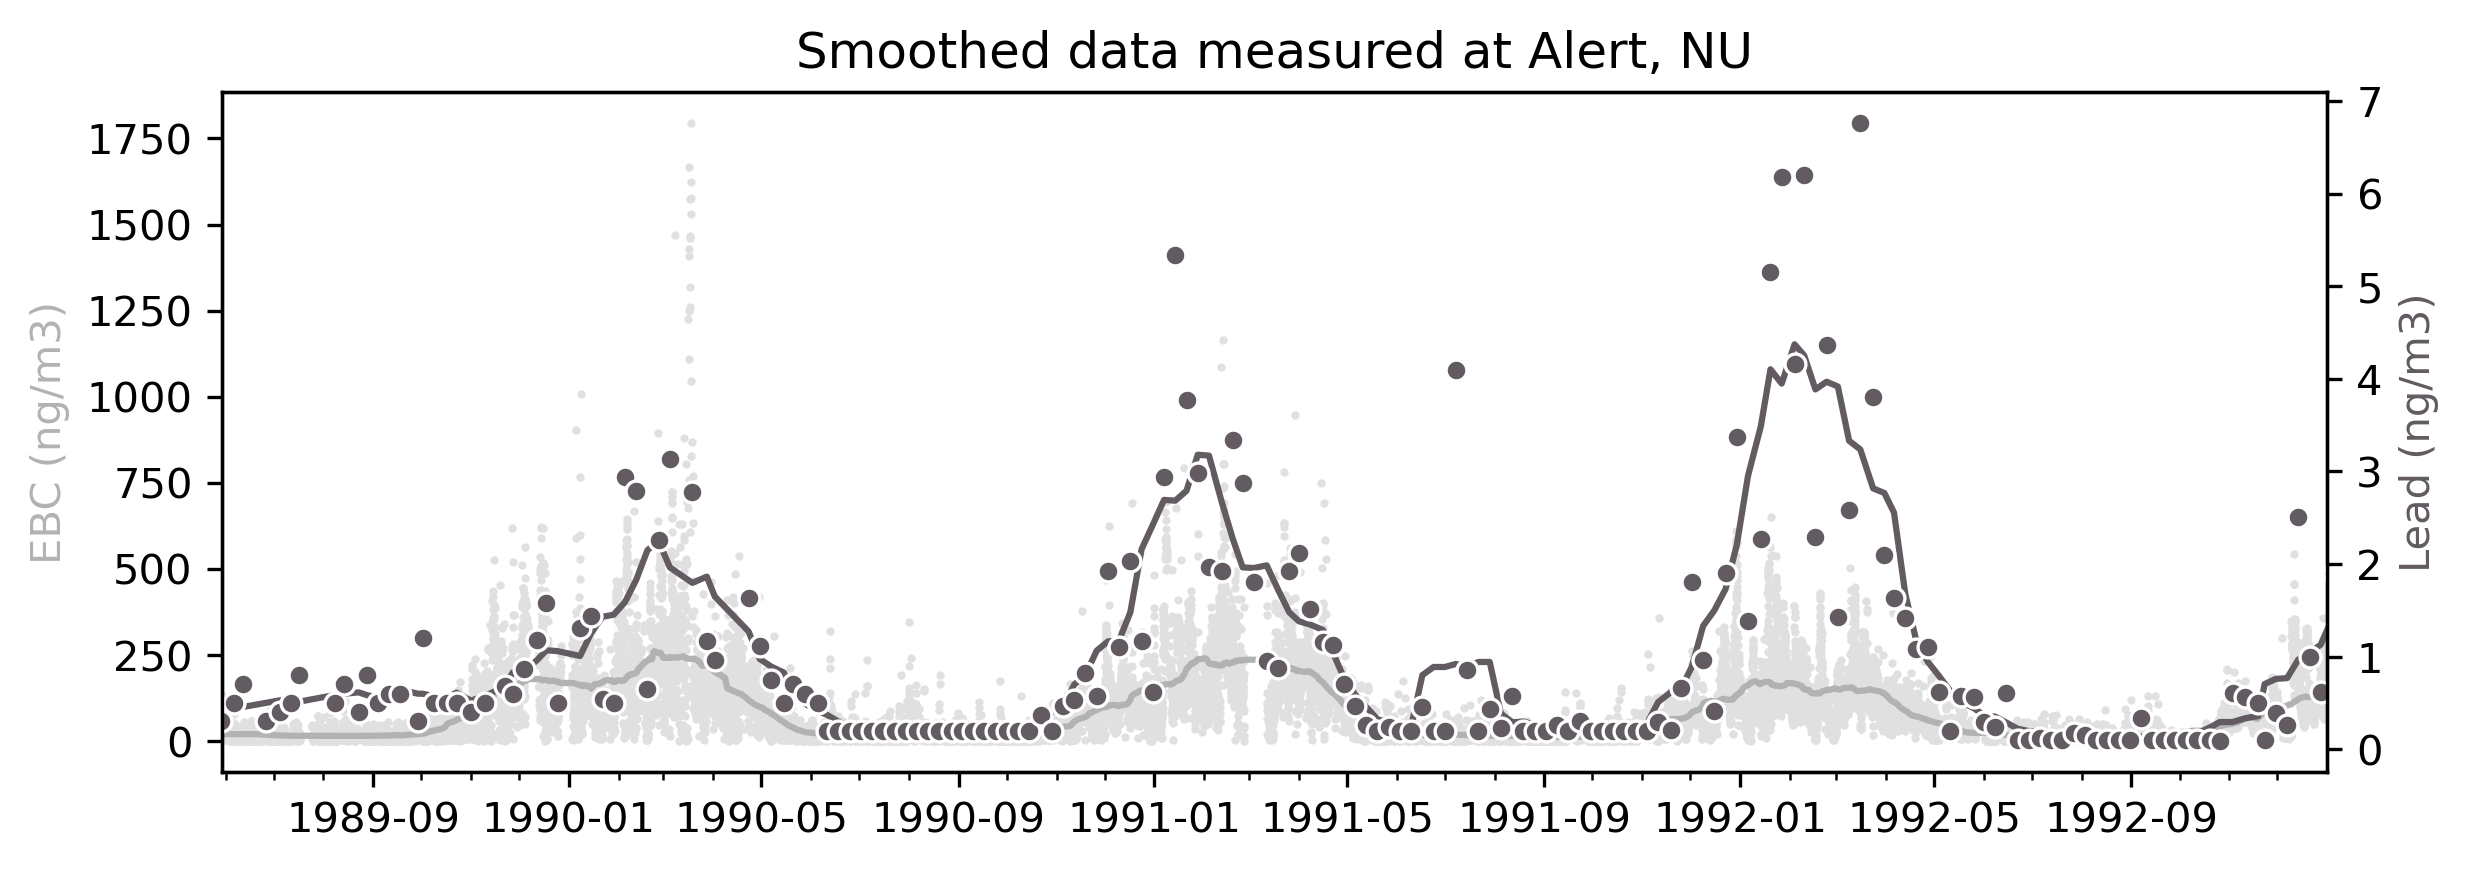

In [126]:
fig, ax1 = plt.subplots(1,1, figsize=(9.055, 3.0), dpi=300)
ax1.plot_date(Alert_EBC_dates, Alert_EBC,'.', color='#e0e0e0', markersize=3, markeredgewidth=0.5)
ax1.plot_date(Alert_EBC_dates, Alert_EBC_ave,'-', color=color_BC)
ax1.set_xlim([Alert_EBC_dates[0], Alert_EBC_dates[-1]])
ax1.set_ylabel('EBC (ng/m3)', fontsize=10, color=color_BC)
ax1.xaxis.set_minor_locator(months)
ax1.set_title('Smoothed data measured at Alert, NU')

ax2 = ax1.twinx()
ax2.plot_date(Alert_Pb_dates, Alert_Pb_ave,'-', color=color_Pb)
ax2.plot_date(Alert_Pb_dates, Alert_Pb,'.', color=color_Pb, markersize=10, markeredgecolor='w', markeredgewidth=0.8)
ax2.set_ylabel('Lead (ng/m3)', fontsize=10, color=color_Pb)
ax2.set_xlim([Alert_EBC_dates[0], Alert_EBC_dates[-1]])

#### bandpass filter:

In [138]:
dt_EBC = (Alert_EBC_dates[1]-Alert_EBC_dates[0]).total_seconds()
amp_EBC = np.fft.rfft(Alert_EBC)
freqs_EBC = np.fft.rfftfreq(Alert_EBC.size,dt_EBC)
phase_EBC = np.arctan2(amp_EBC.imag,amp_EBC.real)

# Apply bandpass filter:
filter_EBC = amp_EBC.copy()
filter_EBC[(freqs_EBC > 3e-7)] = 0
Alert_EBC_filtered = np.fft.irfft(filter_EBC)

In [139]:
dt_Pb    = (Alert_Pb_dates[1]-Alert_Pb_dates[0]).total_seconds()
amp_Pb   = np.fft.rfft(Alert_Pb)
freqs_Pb = np.fft.rfftfreq(Alert_Pb.size,dt_Pb)
phase_Pb = np.arctan2(amp_Pb.imag,amp_Pb.real)

# Apply bandpass filter:
filter_Pb = amp_Pb.copy()
filter_Pb[(freqs_Pb > 2e-7)] = 0
Alert_Pb_filtered = np.fft.irfft(filter_Pb)

In [140]:
# interpolate to same dates:
base = Alert_EBC_dates[0]
diff = (Alert_EBC_dates[-1] - base)
time_grid = [base + datetime.timedelta(days=x) for x in range(0, diff.days)] # interpolated to daily values 

In [141]:
t2_EBC = np.array([toTimestamp(t) for t in Alert_EBC_dates])
t2_Pb = np.array([toTimestamp(t) for t in Alert_Pb_dates])

Alert_EBC_filtered_gridded = np.interp([toTimestamp(t) for t in time_grid], t2_EBC[0:-1], Alert_EBC_filtered)
Alert_Pb_filtered_gridded = np.interp([toTimestamp(t) for t in time_grid], t2_Pb[0:-1], Alert_Pb_filtered)

## Load data from Villum

Black carbon is from May 2011 to August 2013, while Pb goes from 1990-2015

In [170]:
Pb = pd.read_csv('/ocean/brogalla/GEOTRACES/data/Analysis_data_LW_Fly_keld_master_report_SE_out_PB_BC.csv').dropna(subset=['Pb_PIXEICPMS'])
Pb['Date_BASE'] = pd.to_datetime(Pb.Date_BASE[2:])
Villum_Pb       = Pb.sort_values(by='Date_BASE')
Villum_Pb_dates = Villum_Pb['Date_BASE'][0:-2].values
Villum_conc_Pb  = Villum_Pb['Pb_PIXEICPMS'][0:-2].values.astype(float) #ng/m3

In [174]:
# Data source: "Atmospheric black carbon and sulfate concentrations in Northeast Greenland", Andreas Massling
BC = pd.read_csv('/ocean/brogalla/GEOTRACES/data/MAAP_24h_Birgit_final.csv')
BC['Date'] = pd.to_datetime(BC.Date)
Villum_BC       = BC.sort_values(by='Date')
Villum_BC_dates = pd.to_datetime(BC['Date']).values
Villum_conc_BC  = BC['AvgOf24hconc'].values.astype(float) #ng/m3

Raw data:

(0.0, 3.0)

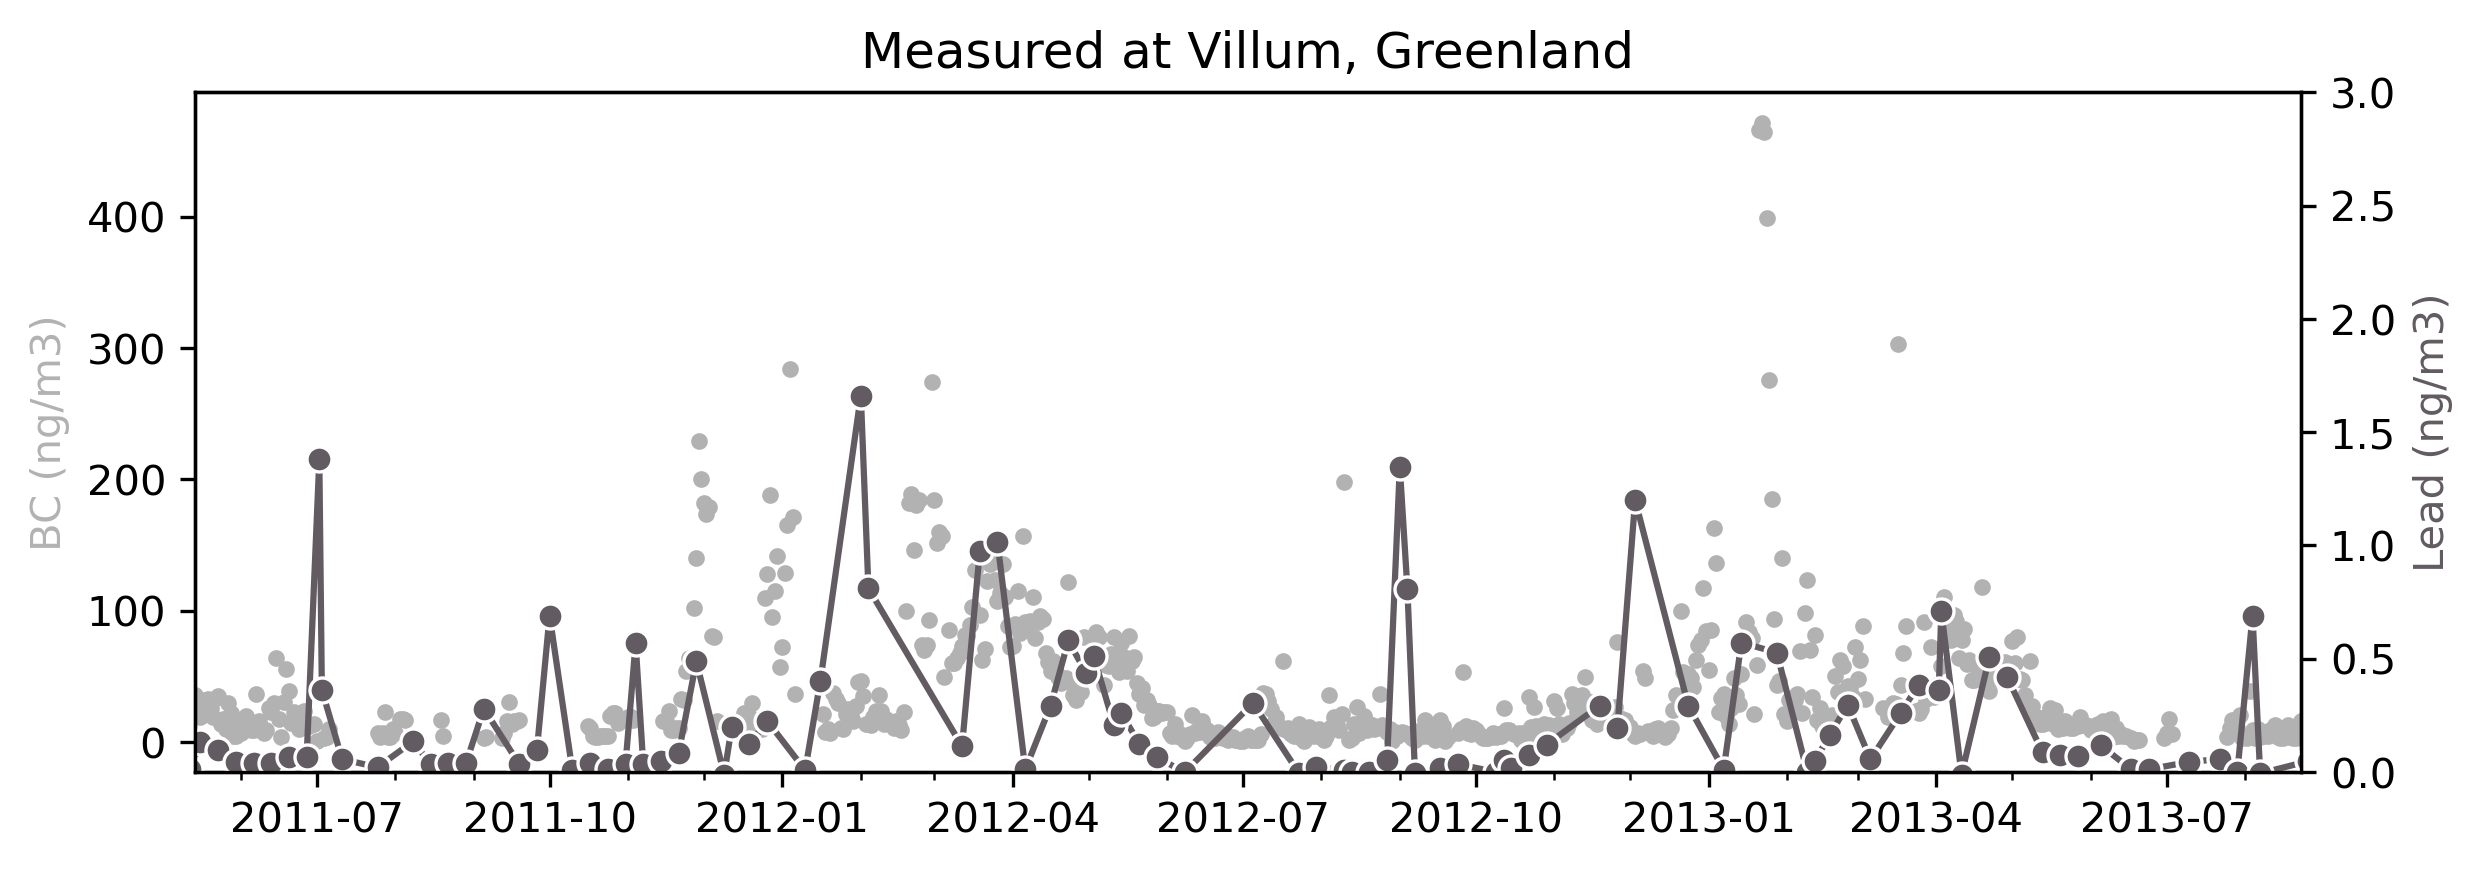

In [176]:
fig, ax1 = plt.subplots(1,1, figsize=(9.055, 3.0), dpi=300)
ax1.plot_date(Villum_BC_dates, Villum_conc_BC,'.', color=color_BC, markersize=6)
ax1.set_xlim([Villum_BC_dates[0], Villum_BC_dates[-1]])
ax1.set_ylabel('BC (ng/m3)', fontsize=10, color=color_BC)
ax1.xaxis.set_minor_locator(months)
ax1.set_title('Measured at Villum, Greenland')

ax2 = ax1.twinx()
ax2.plot_date(Villum_Pb_dates, Villum_conc_Pb,'.-', color=color_Pb, markersize=12, markeredgecolor='w', markeredgewidth=0.8)
ax2.set_ylabel('Lead (ng/m3)', fontsize=10, color=color_Pb)
ax2.set_xlim([Villum_BC_dates[0], Villum_BC_dates[-1]])
ax2.set_ylim([0,3])

### Identify indices of period of overlap:

In [178]:
print('BC: ', Villum_BC_dates[0],'   ', Villum_BC_dates[-1])
print('Pb: ', Villum_Pb_dates[0],'   ', Villum_Pb_dates[-1])

BC:  2011-05-14T00:00:00.000000000     2013-08-23T00:00:00.000000000
Pb:  1990-01-10T00:00:00.000000000     2015-12-28T00:00:00.000000000


In [270]:
indx_BC = np.array([])
indx_Pb = np.array([])

for ind, Pb_date in enumerate(Villum_Pb_dates):
    if (ind > 703) & (ind < 802):
        # Find index of nearest BC date for each Pb measurement:
        indx_add = np.argmin(np.abs(Pb_date - Villum_BC_dates))
        indx_BC  = np.append(indx_BC, int(indx_add))
        # And save index of Pb element too:
        indx_Pb  = np.append(indx_Pb, int(ind))

In [271]:
Villum_Pb_dates_overlap = np.array([Villum_Pb_dates[int(ix)] for ix in indx_Pb])
Villum_conc_Pb_overlap  = np.array([Villum_conc_Pb[int(ix)] for ix in indx_Pb])
Villum_BC_dates_overlap = np.array([Villum_BC_dates[int(ix)] for ix in indx_BC])
Villum_conc_BC_overlap  = np.array([Villum_conc_BC[int(ix)] for ix in indx_BC])

In [279]:
# Monthly smoothing:
Villum_Pb_ave = smooth(Villum_conc_Pb, window_len=5, window='flat')[2:-2]
Villum_Pb_ave_overlap = smooth(Villum_conc_Pb_overlap, window_len=5, window='flat')[2:-2]
Villum_BC_ave_overlap = smooth(Villum_conc_BC_overlap, window_len=5, window='flat')[2:-2]

(0.0, 2.0)

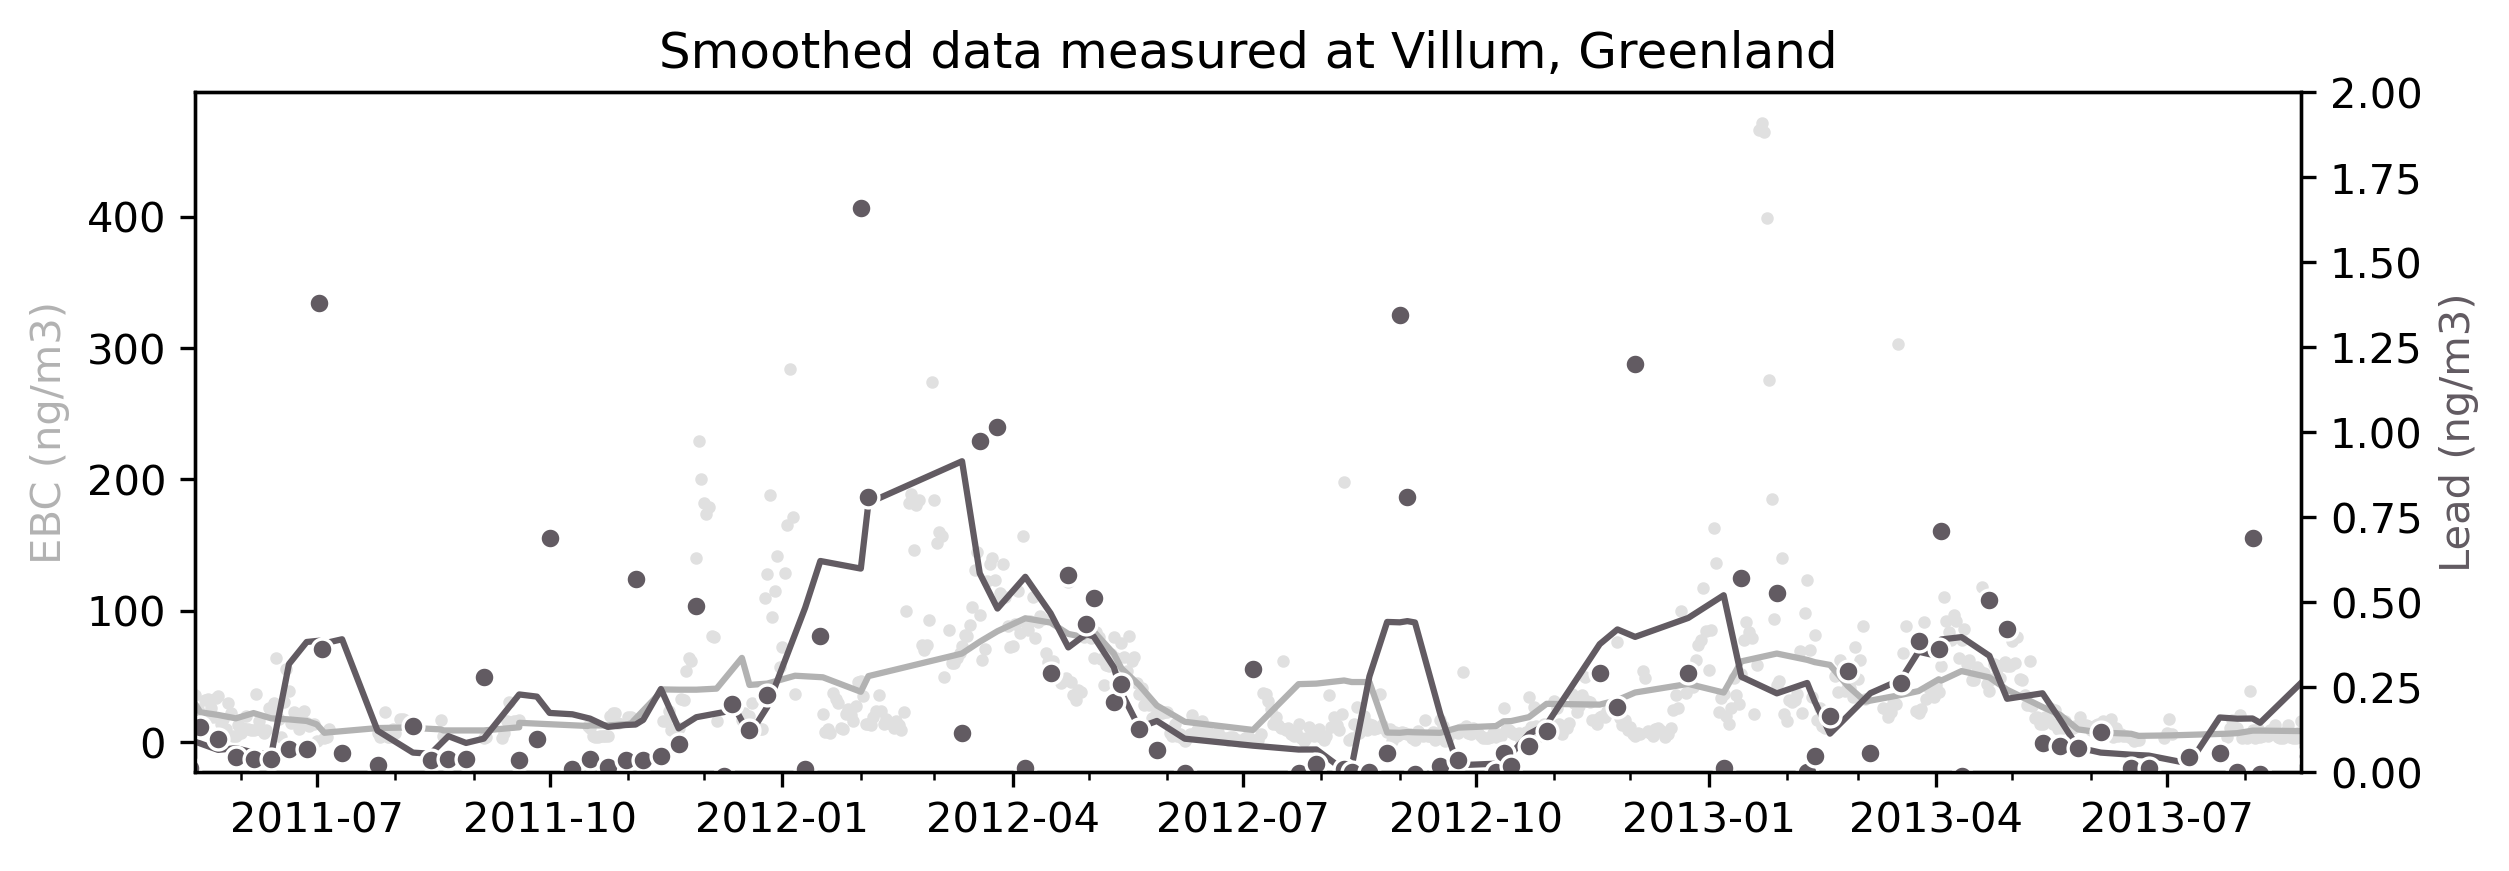

In [281]:
fig, ax1 = plt.subplots(1,1, figsize=(9.055, 3.0), dpi=300)
ax1.plot_date(Villum_BC_dates, Villum_conc_BC,'.', color='#e0e0e0', markersize=5, markeredgewidth=0.5)
ax1.plot_date(Villum_BC_dates_overlap, Villum_BC_ave_overlap,'-', color=color_BC)
ax1.set_xlim([Villum_BC_dates_overlap[0], Villum_BC_dates_overlap[-1]])
ax1.set_ylabel('EBC (ng/m3)', fontsize=10, color=color_BC)
ax1.xaxis.set_minor_locator(months)
ax1.set_title('Smoothed data measured at Villum, Greenland')

ax2 = ax1.twinx()
ax2.plot_date(Villum_Pb_dates_overlap, Villum_Pb_ave_overlap,'-', color=color_Pb)
ax2.plot_date(Villum_Pb_dates_overlap, Villum_conc_Pb_overlap,'.', color=color_Pb, markersize=10, markeredgecolor='w', markeredgewidth=0.8)
ax2.set_ylabel('Lead (ng/m3)', fontsize=10, color=color_Pb)
ax2.set_xlim([Villum_BC_dates_overlap[0], Villum_BC_dates_overlap[-1]])
ax2.set_ylim([0,2])

In [284]:
# Combine data from both datasets for linear fit:
combined_EBC = np.append(Alert_EBC_filtered_gridded[::10], Villum_BC_ave_overlap)
combined_Pb  = np.append(Alert_Pb_filtered_gridded[::10], Villum_Pb_ave_overlap)

p1, f = lin_fit(combined_EBC, combined_Pb)
print(p1, 1/p1) # Pb = ratio*BC

[0.01098668] [91.0192939]


(0.0, 6.0)

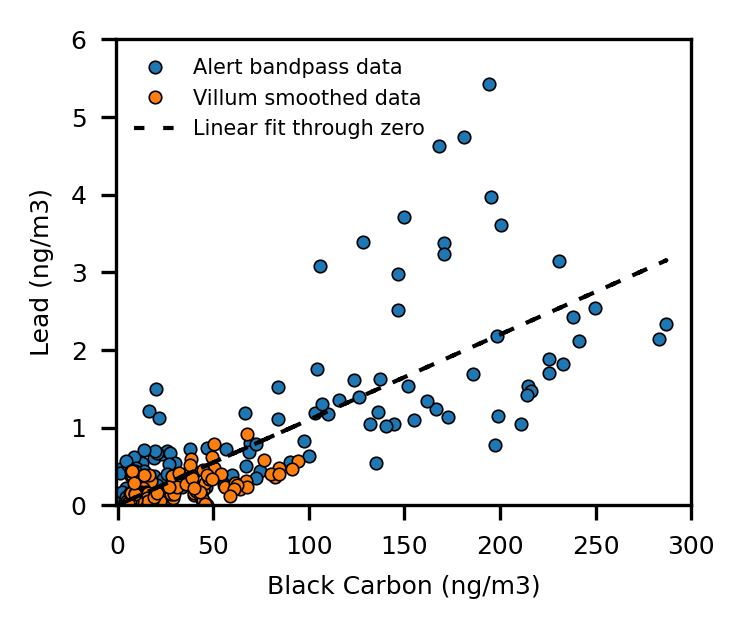

In [288]:
scale = 0.55
fig, ax1 = plt.subplots(1,1, figsize=(4.5*scale, 3.74*scale), dpi=300)
ax1.plot(Alert_EBC_filtered_gridded[::10], Alert_Pb_filtered_gridded[::10], '.', \
         markersize=6, markeredgecolor='k', markeredgewidth=0.4, label='Alert bandpass data')
ax1.plot(Villum_BC_ave_overlap, Villum_Pb_ave_overlap, '.', \
         markersize=6, markeredgecolor='k', markeredgewidth=0.4, label='Villum smoothed data')
ax1.plot(combined_EBC, f, '--k', linewidth=1.0, label="Linear fit through zero", dashes=(2.5,4.5))
ax1.set_ylabel('Lead (ng/m3)', fontsize=6)
ax1.set_xlabel('Black Carbon (ng/m3)', fontsize=6)
ax1.tick_params(axis='both', labelsize=6)
ax1.legend(fontsize=5, loc=2, frameon=False)
ax1.set_xlim([-1, 300])
ax1.set_ylim([-0, 6])

In [297]:
print('Correlation after smoothing and filtering:')
print(f'Pearson r value: {pearsonr(combined_EBC, combined_Pb)[0]:.2f}')
print(f'Spearman r value: {spearmanr(combined_EBC, combined_Pb)[0]:.2f}') # rank correlation

Correlation after smoothing and filtering:
Pearson r value: 0.76
Spearman r value: 0.67


In [346]:
# Combine data from both datasets for linear fit:
combined_EBC_start = np.append(Alert_EBC_overlap, Villum_conc_BC_overlap)
combined_Pb_start  = np.append(Alert_Pb_overlap, Villum_conc_Pb_overlap)

In [347]:
print('Correlation before smoothing and filtering:')
print(f'Pearson r value: {pearsonr(combined_EBC_start, combined_Pb_start)[0]:.2f}')
print(f'Spearman r value: {spearmanr(combined_EBC_start, combined_Pb_start)[0]:.2f}') # rank correlation

Correlation before smoothing and filtering:
Pearson r value: 0.55
Spearman r value: 0.52
